<h1 style="text-align:center">Decision Tree</h1>

[Tutorial](https://machinelearningcoban.com/tabml_book/ch_model/decision_tree.html?fbclid=IwAR1RTwuA9zgihGVN9Mam8E76Ha9OM7P49NhT-SDjcXB2qbDJAVazKO79j8U)

In [1]:
import pandas as pd
link = "https://media.githubusercontent.com/media/tiepvupsu/tabml_data/master/titanic/"
df = pd.read_csv(link + "train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [93]:
title_mapping = {"Mr" : 1, "Mrs": 2, "Miss": 3, "Rev": 4, "Master": 5}
sex_mapping = {"male" : 1, "female": 2}

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, load_iris

In [162]:
data = load_iris().data
labels = load_iris().target
n_samples = len(labels)

data_set = np.c_[data, labels]
# labels

data_set = data_set[np.random.permutation(n_samples)]
data_train_set = data_set[: int(0.77 * n_samples)]
data_test_set = data_set[int(0.77 * n_samples):]

In [108]:
class Node:
    def __init__(self, feature_index = None, threshold = None, left = None, right = None, label = None):
        """
        Node:
        Attribute
        Threshold
        left
        right
        label
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        
        # Leaf Node
        self.label = label

In [175]:
class DecisionTree:
    def __init__(self, max_depth = 5, min_group = 2):
        # Root tree
        self.root = None
        
        # Max depth
        self.max_depth = max_depth
#       self.min_group = min_group
        
    # Condition stop
    def should_stop(self, datasets, depth):
        return (not np.any(datasets)) or depth > self.max_depth
        
    def build_tree(self, datasets, depth, mode):
        if self.should_stop(datasets, depth): return None
        
        n_class = len(np.unique(datasets[:, -1]))
        node_root = Node()
        
        # Only contain 1 class 
        if n_class == 1: 
            node_root.label = datasets[0, -1]
            return node_root
            
        node_info = {}
        max_info_gain = - float("inf")
        _, n_features = datasets.shape
        n_features -= 1
        
        # Loop over all feature to find max information gain
        for feature_index in range(n_features):
            data_idx = datasets[:, feature_index]
            
            # Loop over all data
            for threshold in data_idx:
                # Split data based on feature threshold
                cur_data_left, cur_data_right = self.split_data(datasets, feature_index, threshold)
                
                # Ignore min-max value
                if len(cur_data_left) > 0 and len(cur_data_right) > 0:
                    
                    # Calc information gain
                    cur_info_gain = self.information_gain(datasets, cur_data_left, cur_data_right, mode)
                    if cur_info_gain > max_info_gain:
                        
                        # Update node_info
                        max_info_gain = cur_info_gain
                        node_info["data_left"] = cur_data_left
                        node_info["data_right"] = cur_data_right
                        node_info["feature_index"] = feature_index
                        node_info["threshold"] = threshold

        # Build child node
        node_left = self.build_tree(node_info["data_left"], depth + 1, mode)
        node_right = self.build_tree(node_info["data_right"], depth + 1, mode)
        node_root.left = node_left
        node_root.right = node_right
        node_root.feature_index = node_info["feature_index"]
        node_root.threshold = node_info["threshold"]
        
        # Max depth and not completed spliting yet -> choose random class
        if depth == self.max_depth:
            rand_idx = int(np.random.rand() * datasets.shape[0])
            node_root.label = datasets[rand_idx, -1]
        
        return node_root
    
    # Function to split data based on threshold
    def split_data(self, dataset, feature_index, threshold):
        data_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        data_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return data_left, data_right
    
    # Function to calc information gain
    def information_gain(self, datasets, data_left, data_right ,mode = "gini"):
        count_ = len(datasets)
        count_left = len(data_left)
        count_right = len(data_right)
        weight = np.array([count_left, count_right]) / count_
        
        if mode == 'gini':
            root_info = self.gini(datasets)
            child_info = np.array([self.gini(data_left), self.gini(data_right)])
        else:
            root_info = self.entropy(datasets)
            child_info = np.array([self.entropy(data_left), self.entropy(data_right)])
        return root_info - weight.T @ child_info
            
    def entropy(self, datasets):
        _, counts = np.unique(datasets[:, -1], return_counts = True)
        total = counts.sum()
        prob = counts / total
        return - np.sum(prob * np.log2(prob), axis = 0)
    
    def gini(self, datasets):
        _, counts = np.unique(datasets[:, -1], return_counts = True)
        total = counts.sum()
        prob = counts / total
        return 1 - np.sum(prob ** 2, axis = 0)
        
    
    def fit(self, datasets, mode = 'gini'):
        self.root = self.build_tree(datasets, 0, mode)
        return self.root
    
    def predict(self, X):
        node_res = self.root
        while node_res.label is None:
#             print(f"Feature index: {node_res.feature_index}, threshold: {node_res.threshold}")
            if X[node_res.feature_index] <= node_res.threshold:
                node_res = node_res.left
            else:
                node_res = node_res.right
                
        return node_res.label


In [176]:
dct = DecisionTree()

In [177]:
dct.fit(data_train_set, "entroyp")

In [185]:
def calculate_accuracy(dct, data_test_set):
    acc = 0
    n_test_samples = len(data_test_set)
    for data_i in data_test_set:
        res = dct.predict(data_i)
        acc += res == data_i[-1]
    print(f"Total accuracy: {acc / n_test_samples}")
    return acc / n_test_samples

In [186]:
acc_list = []

for i in range(100):
    data_set = data_set[np.random.permutation(n_samples)]
    data_train_set = data_set[: int(0.77 * n_samples)]
    data_test_set = data_set[int(0.77 * n_samples):]
    
    dct = DecisionTree()
    dct.fit(data_train_set)
    acc_list.append(calculate_accuracy(dct, data_test_set))

Total accuracy: 0.9428571428571428
Total accuracy: 0.9714285714285714
Total accuracy: 0.9428571428571428
Total accuracy: 0.9428571428571428
Total accuracy: 0.8285714285714286
Total accuracy: 0.9142857142857143
Total accuracy: 0.9428571428571428
Total accuracy: 0.9142857142857143
Total accuracy: 0.9428571428571428
Total accuracy: 0.9142857142857143
Total accuracy: 0.9142857142857143
Total accuracy: 0.9428571428571428
Total accuracy: 0.9428571428571428
Total accuracy: 0.9142857142857143
Total accuracy: 0.8571428571428571
Total accuracy: 0.9714285714285714
Total accuracy: 0.9714285714285714
Total accuracy: 0.9428571428571428
Total accuracy: 0.9142857142857143
Total accuracy: 0.9142857142857143
Total accuracy: 0.9428571428571428
Total accuracy: 0.9428571428571428
Total accuracy: 0.9714285714285714
Total accuracy: 0.9428571428571428
Total accuracy: 0.9142857142857143
Total accuracy: 0.8857142857142857
Total accuracy: 0.8857142857142857
Total accuracy: 0.9428571428571428
Total accuracy: 0.94

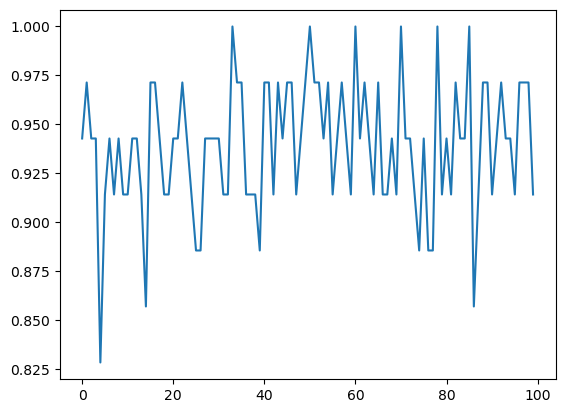

In [188]:
plt.plot(np.arange(100), np.array(acc_list));